# Introduction

The project work implements the paper Students need more attention which mainly discusses on modifying Bi-directional Encoder Representations from Transformers(BERT) model to classify text data which are imbalanced and small. The general observation from authors is even though deep learning models like CNN, LSTM, BERT perform better than traditional models like SVM, linear regression they tend to overfit for use cases where the dataset is small and imbalanced.

**Problem:**

Deep learning models, like BERT, are powerful tools but require a vast amount of data for training.
In healthcare, datasets are often limited due to privacy concerns and the nature of medical information.
Small datasets can lead to overfitting, where the model performs well on the training data but poorly on unseen data.

**Proposed Solution:**

The paper introduces a novel framework called LESA-BERT (Label Embeddings for Self-Attention BERT). It builds upon BioBERT, a pre-trained model specifically for biomedical text mining. LESA-BERT incorporates two key elements:

**1. Label Embeddings for Self-Attention:** This injects label information into the self-attention mechanism of BERT at every layer. Self-attention allows the model to focus on important parts of the text relevant to the task. By including label information, the model can better learn patterns that differentiate between urgency levels in patient messages.

**2. Knowledge Distillation:** Large models like LESA-BERT can be prone to overfitting on small datasets. The paper addresses this by employing a technique called knowledge distillation. Here, a smaller "student" model is trained to mimic the predictions of the larger "teacher" model (LESA-BERT). This compressed student model inherits the knowledge of the teacher but with fewer parameters, reducing overfitting risks.


In [ ]:
# code comment is used as inline annotations for your coding

# Scope of Reproducibility:

Below are the hypothesus from the paper we will test.

1.   Hypothesis 1:  Large models overfit to small imbalanced datasets.
2.   Hypothesis 2:  The proposed model LESA-BERT provides better performance compared to other techniques such as vanilla BERT, CNN etc

In order to run the experiments we will train the below models with multiple datasets and different hyperparameter setting

1. BERT base
2. BERT large
3. LESA BERT
4. Distil BERT
5. RoberTA
6. CNN




# Methodology

The code base for the project is uploaded in a public github repo. The repo consists of data and model code used for training the model. Lets start by downloading the code repo

In [ ]:
# import  packages you need
! git clone https://github.com/aruncs2005/textclassifiers.git


## Environment Setup

We use docker based environment as the code needs specific versions of libraries and CUDA version to run the training job. The training environment is depicted below

1. Python Version - 3.6
2. Pytorch version - 1.6
3. CUDA version - 9.2

All the training jobs are run using T4 GPU on AWS. We used Amazon SageMaker notebook instance with G4dn.xlarge as instance type. The code can be reproduced using similar instances or even a CPU based instance which has docker installed.


### 1. Prerequisities

Install docker - The host machine should have docker setup inorder to build the image and run training jobs. Please use the below link to setup docker based on the OS on your host machine - https://docs.docker.com/engine/install/

Note: Amazon SageMaker notebook instances come with docker preinstalled.


### 2. Build the docker image

Please follow the below instructions to setup the code

#### clone the repo
``` git clone https://github.com/aruncs2005/textclassifiers.git ```

#### build the docker image
``` cd textclassifiers && docker build -t image_classifier . ```

#### install nvidia container toolkit

#### To install on AL2
``` sudo yum install -y nvidia-container-toolkit ```

#### To install on ubuntu
``` sudo apt-get install -y nvidia-container-toolkit ```


##  Data
The data used in the paper is not openly available for further experiments. For this project we will use similar text classification datasets. We are using multiple datasets to test the models general- ization capabilities. Also using a different dataset from the original paper helps us to validate the hypothesis made by authors. Below are the datasets we use for this project
1. **Medical-Abstracts-TC-Corpus** - This repository contains a medical abstracts dataset, de- scribing 5 different classes of patient conditions including Neoplasms,Digestive system diseases, Nervous system diseases,Cardivascular diseases and General pathological conditions. The dataset can be used for text classification. The dataset can be found here - https://github.com/sebischair/Medical-Abstracts-TC-Corpus
2. **Illness-dataset** - the dataset consists of 22,660 documents (tweets) collected in 2018 and 2019. It spans across four domains: Alzheimer’s, Parkinson’s, Cancer, and Diabetes. We will reduce the number of samples to match the requirements depicted in the paper. The dataset can be found here - https://github.com/p-karisani/illness-dataset
3.**Patient Reviews** - The dataset contains German doctor reviews from 2021 Containing 439280 rows, each row stands for a review submitted by a patient and includes a numerical rating as well as text comment about their experience with the doctor. The ratings range from 1 (the best) to 6, and the comments are raw texts that have not been preprocessed or cleaned. We have taken a smaller version of the dataset for this project. The dataset can be found here - https://www.kaggle.com/datasets/thedevastator/german-2021-patient-reviews-and-ratings-of-docto
4. **MRPC** - Microsoft Research Paraphrase Corpus (MRPC) is a corpus consists of 5,801 sentence pairs collected from newswire articles. Each pair is labelled if it is a paraphrase or not by human annotators. The whole set is divided into a training subset (4,076 sentence pairs of which 2,753 are paraphrases) and a test subset (1,725 pairs of which 1,147 are paraphrases). The datset can be found here - https://www.microsoft.com/en-us/download/details.aspx?id=52398

Lets take a look at each dataset and prepare the dataset required for training.

#### 1. Medical-Abstracts-TC-Corpus

The dataset consists for 5 labels and the dataset is slightly imbalanced. Also we see each label has atleast 1000 samples. For preprocessing we will do the below

1.   Reduce the number of samples to approximately around 100
2.   Downsample data for some of the labels to make the dataset more imbalanced.
3. Filter out large texts to make sure we stick to the hypothesis.



In [ ]:
import pandas as pd

def main():
    data = pd.read_csv("data/medabstracts/medical_tc_train.csv")
    data = data.rename({'condition_label': 'label', 'medical_abstract': 'text'}, axis=1)

    data["text_length"] = data["text"].str.split(" ")
    data = data[data['text_length'].map(len) < 100]
    data = data.drop('text_length', axis=1)
    columns_titles = ["text","label"]
    data=data.reindex(columns=columns_titles)

    sample = 1500
    col_name = "label"

    probs = data[col_name].map(data[col_name].value_counts())
    data = data.sample(n=sample, weights=probs)
    print(f"Number of samples in train dataset {len(data.index)}")
    data.to_csv("data/medabstracts/train.csv",index=False)

    # process test data

    data = pd.read_csv("data/medabstracts/medical_tc_test.csv")
    data = data.rename({'condition_label': 'label', 'medical_abstract': 'text'}, axis=1)


    data["text_length"] = data["text"].str.split(" ")
    data = data[data['text_length'].map(len) < 100]
    data = data.drop('text_length', axis=1)
    columns_titles = ["text","label"]
    data=data.reindex(columns=columns_titles)

    sample = 300
    col_name = "label"

    probs = data[col_name].map(data[col_name].value_counts())
    data = data.sample(n=sample, weights=probs)
    print(f"Number of samples in test dataset {len(data.index)}")
    data.to_csv("data/medabstracts/test.csv",index=False)


if __name__ == "__main__":
    main()

In [ ]:
# Below code does preprocessing and store the train

[link text](https://)The dataset is reduce to 1100 samples and the labels are also imbalanced especially label 2 and 3.

Save the dataset to be used for training

In [ ]:
processed_data.to_csv("data/medabstracts/train.csv",index=False)

#### 2. Illness Dataset

In [ ]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split

def remove_urls(text, replacement_text=""):
    # Define a regex pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Use the sub() method to replace URLs with the specified replacement text
    text_without_urls = url_pattern.sub(replacement_text, text)

    return text_without_urls

def main():
    mapping = {"alzheimer":1,"parkinson":2,"cancer":3,"diabetes":4}
    file = open("textclassifiers/data/illness/data.txt",encoding="utf-8")

    Lines = file.readlines()
    dataset = []
    for line in Lines:
        input = line.split("\t")
        item = {}
        item["text"] = remove_urls(input[2]).replace("\"","")
        item["label"] = mapping[input[0]]
        dataset.append(item)

    dataDf = pd.DataFrame(dataset)

    sample = 1000
    col_name = "label"

    probs = dataDf[col_name].map(dataDf[col_name].value_counts())
    dataDf = dataDf.sample(n=sample, weights=probs)

    #print(dataDf.head())
    traindf, testdf = train_test_split(dataDf, test_size=0.2, random_state=42, shuffle=True)
    print(f"Number of samples in train dataset {len(traindf.index)}")
    print(f"Number of samples in test dataset {len(testdf.index)}")

    traindf.to_csv("data/illness/train.csv",index=False)
    testdf.to_csv("data/illness/test.csv",index=False)



if __name__ == "__main__":
    main()

#### 3. Patient Reviews Dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split


def main():
    trainData = pd.read_csv("data/patient_reviews/reviews_small.csv")

    trainData = trainData[["rating","comment"]]
    print(len(trainData.index))
    trainData = trainData.rename({'rating': 'label', 'comment': 'text'}, axis=1)

    trainData["text_length"] = trainData["text"].str.split(" ")
    trainData = trainData[trainData['text_length'].map(len) < 100]
    trainData = trainData.drop('text_length', axis=1)

    columns_titles = ["text","label"]
    trainData=trainData.reindex(columns=columns_titles)


    sample = 1500
    col_name = "label"

    probs = trainData[col_name].map(trainData[col_name].value_counts())
    trainData = trainData.sample(n=sample, weights=probs)

    print(len(trainData.index))

    traindf, testdf = train_test_split(trainData, test_size=0.2, random_state=42, shuffle=True)

    print(f"Number of samples in train dataset {len(traindf.index)}")
    print(f"Number of samples in test dataset {len(testdf.index)}")

    traindf.to_csv("data/patient_reviews/train.csv",index=False)
    testdf.to_csv("data/patient_reviews/test.csv",index=False)



if __name__ == "__main__":
    main()

#### 4. MRPC dataset

This dataset is used to reproduce the open sourced observation from the author. This dataset is part of glue tasks and doesn't need any pre processing. We will use the downloaded data at data/MRPC to run the training.

##   Model

### BERT

The project uses BERT and its variations to test different hypothesis. BERT is a Decoder only Transformer Architecture and uses AutoEncoding objective for training. BERT is generally trained in 2 phases
1. Unsupervised Pretraining on Large corpus of Data, followed by
2. Fine tuning on supervised data like text classification, Question Answering etc.

BERT is pretrained on two unsupervised objectives

1) Masked LM - Here random input tokens are re- place by a < MASK > token and fed into the network. The goal is to learn from deep bidirectional context and predict the < MASK > tokens in the input sequence. The task uses cross entropy loss to compare predicted tokens with ground truth and update the model parameters

2) Next Sentence Prediction (NSP)- In order to make sure the model can be used on downstream tasks such as Ques- tion Answering which spans multiple sentences, BERT is trained to predict whether 2 sentences in a corpus occur one after the other. NSP uses cross entropy as loss function to update the model parameters.

BERT was trained on a large corpus of unstructed data spanning to 16 GB in size which included Book Corpus and English wikipedia. BERT was trained on 2 model sizes which includes BERT BASE (110 million Parameters) and BERT LARGE (340M parameters)

In this project we use BERT for text classification. The below image shows the high level architecture



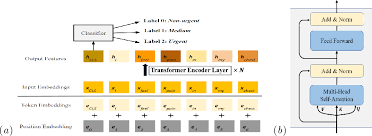




BERT model structure for text classification.Token and position embeddings are summed up as input embeddings, then fed through N transformer encoder layers, yielding a high-level representations (features) for classification.


The image below describes the usage of label embeddings along with BERT. This mainly consists of

(a) Incorporating label embeddings to the multi-head self-attention in BERT.

(b) Modifying self-attention scores with label embeddings. L indicates row concatenation


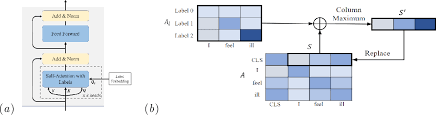



Lets take a look at the model code specifically for label embeddings. We modify the BERT layers such as embeddings, Attention to accomodate the addition of label embeddings. Below code block depicts the changes in each layer.

In [ ]:
# Embedding layer
#self.label_embeddings = nn.Parameter(torch.zeros(num_labels, config.hidden_size))#nn.Embedding(num_labels, config.hidden_size)

#Attention layer forward, combine label embeddings with query

# lb_embeddings = label_embeddings[label_ids]
# lb_embeddings = lb_embeddings.expand(batch_size, num_labels, hidden_size)
# mixed_lb_query = self.query(lb_embeddings)
# lb_query = self.transpose_for_scores(mixed_lb_query)

The model training cannot be conducted on a colab environment as it uses a specific versions of python and pytorch. We have build a docker file that can be used to create an environment and test the model training.

In [ ]:

# Please follow the below instructions to setup the code

# start the docker image

! docker run -it  --runtime=nvidia --gpus all -v <full_path_to>/text_classifiers:/workspace/text_classifiers text_classifiers:latest

# once you are in the container to start the training use

! bash run_bert.sh # for bert based training
! bash run_label_bert.sh # for label embeddings based training


### CNN Model

Convolutional Neural Networks(CNNs) are structured to automatically learn spatial hierarchies of features from low to high-level patterns. The key components of a CNN include convolution layers, pooling layers, and fully connected layers. Convolution layers apply filters to extract features, pooling layers downsample data, and fully connected layers make final predictions. The below figure shows how CNN can be used for text classification by combining a series of convolutions finally by using a full connected layer for classification.

<img src="https://miro.medium.com/v2/resize:fit:4800/format:webp/0*SjaW0zqH8g6VIz7w.png">

In [ ]:

# Please follow the below instructions to setup the code

# start the docker image

! docker run -it  --runtime=nvidia --gpus all -v <full_path_to>/text_classifiers:/workspace/text_classifiers text_classifiers:latest

# once you are in the container to start the training use

! bash run_cnn.sh # for bert based training


### DistilBERT

 DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than google-bert/bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

 <img src="https://www.researchgate.net/profile/Alhassan-Mabrouk/publication/358239462/figure/fig2/AS:1120931644747777@1644262338087/The-DistilBERT-model-architecture-and-components.png">

As shown in teh figure, A smaller DistilBERT model is trained to reproduce the outputs of the pre-trained BERT model on the same data. This is done by defining a loss function that combines three components:
**Masked language modeling loss**: To learn the core language modeling task.
**Distillation loss**: To match the output probabilities of BERT.
**Similarity loss**: To ensure the hidden state embeddings of DistilBERT are similar to BERT's.

In [ ]:

# Please follow the below instructions to setup the code

# start the docker image

! docker run -it  --runtime=nvidia --gpus all -v <full_path_to>/text_classifiers:/workspace/text_classifiers text_classifiers:latest

# once you are in the container to start the training use

! bash run_distil_bert.sh # for bert based training


# Results

We have used accuracy and F1 score to test the model. Below are the results when trained on 2 different settings

1. BERT Based Model


    acc = 0.8259803921568627
    acc_and_f1 = 0.8533263305322129
    f1 = 0.880672268907563


2. BERT with label embeddings


    acc = 0.8480392156862745
    acc_and_f1 = 0.8714772349617813
    f1 = 0.8949152542372881



## Model comparison

We can see that the label embeddings model performs slightly better than the plain BERT model. We will continue to test the variations with different dataasets.

# Discussion

The Draft only explores the label embeddings model that the original paper discusses and compares it with BERT based model. For the final submission we are looking to add the below features

1.   Implement other models like CNN based classifiers and distillbert to compare performances
2.  Test the hypothesis of model distillation lowers overfitting.
3. The codebase is currently running with older versions of torch and transformers. We couldn't get the updated version working for the draft. We will update and simplify the codebase.
4. Currently the codebase runs with a docker environment due to its dependencies on certain python and torch version. The upgrade will make sure to eliminate the need of docker builds.
5. We will use additional datasets mentioned above to run the tests.
6. Provide graphical evaluation results.



In [ ]:
# no code is required for this section
'''
if you want to use an image outside this notebook for explanaition,
you can read and plot it here like the Scope of Reproducibility
'''

## Video Presentation

The video explaining the paper and our experiments is uploaded in google drive and can be publicly accessed using the below link

https://drive.google.com/file/d/1iWARpnqWEWQ79NUqiNbt9Ms2hndyRUkR/view?usp=sharing

# References

1.   Sun, J, [paper title], [journal title], [year], [volume]:[issue], doi: [doi link to paper]

